<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%204/12_CCA_Elements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- Using Mendeleev library: https://github.com/lmmentel/mendeleev/

In [2]:
import sqlalchemy
print(sqlalchemy.__version__)

2.0.20


First, we need to downgrade sqlalchemy to avoid conflict between versions:


In [3]:
!pip install -U mendeleev
!pip install --upgrade 'sqlalchemy<2.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.20
    Uninstalling SQLAlchemy-2.0.20:
      Successfully uninstalled SQLAlchemy-2.0.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.49 which is incompatible.


Restart the runtime and proceed to run the code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mendeleev

from mendeleev.fetch import fetch_table

# Mendeleev library

Let's see what this library ccontains

In [2]:
from mendeleev import Si, Fe, O
print("Si's name: ", Si.name)
print("Fe's atomic number:", Fe.atomic_number)
print("O's atomic weight: ", O.atomic_weight)

Si's name:  Silicon
Fe's atomic number: 26
O's atomic weight:  15.999


Explore the attributes that contain the information for each element

In [3]:
Si.*?

In [4]:
from mendeleev.fetch import fetch_table

ptable = fetch_table('elements')
ptable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   annotation                     118 non-null    object 
 1   atomic_number                  118 non-null    int64  
 2   atomic_radius                  90 non-null     float64
 3   atomic_volume                  91 non-null     float64
 4   block                          118 non-null    object 
 5   density                        118 non-null    float64
 6   description                    109 non-null    object 
 7   dipole_polarizability          117 non-null    float64
 8   electron_affinity              77 non-null     float64
 9   electronic_configuration       118 non-null    object 
 10  evaporation_heat               88 non-null     float64
 11  fusion_heat                    75 non-null     float64
 12  group_id                       90 non-null     flo

In [5]:
from mendeleev.vis import create_vis_dataframe, periodic_table_plotly

elements = create_vis_dataframe()
periodic_table_plotly(elements)

Experiment with other visualization options!

# Canonical Correlation Analysis

Now, let's experiment with CCA on the elements. Let's first create a table of (some) properties that we are interested in.

In [6]:
cols = ['atomic_number', 'symbol', 'atomic_radius','covalent_radius_cordero', 'covalent_radius_pyykko', 'vdw_radius_mm3', 'en_pauling', 'en_allen']
ptable[cols].head()

,atomic_number,symbol,atomic_radius,covalent_radius_cordero,covalent_radius_pyykko,vdw_radius_mm3,en_pauling,en_allen
0,1,H,25.0,31.0,32.0,162.0,2.20,13.610
1,2,He,120.0,28.0,46.0,153.0,NaN,24.590
2,3,Li,145.0,128.0,133.0,255.0,0.98,5.392
3,4,Be,105.0,96.0,102.0,223.0,1.57,9.323
4,5,B,85.0,84.0,85.0,215.0,2.04,12.130


And make sure that we do not have NaNs

In [7]:
ptable2 = ptable[cols].dropna()
ptable2.tail()

,atomic_number,symbol,atomic_radius,covalent_radius_cordero,covalent_radius_pyykko,vdw_radius_mm3,en_pauling,en_allen
78,79,Au,135.0,136.0,124.0,243.0,2.4,11.33
79,80,Hg,150.0,132.0,133.0,253.0,1.9,10.44
81,82,Pb,180.0,146.0,144.0,274.0,1.8,10.97
82,83,Bi,160.0,148.0,151.0,266.0,1.9,11.90
83,84,Po,190.0,140.0,145.0,259.0,2.0,13.00


Here we are going to create the X and Y data sets. Here, this selection is  arbitary and is used to illustarte the method. We randomly assign the atomic number, two types of atomic radiim, and Pauling electronegativity to X, and two othe rtypes of radii and Allen electronegativity to Y.

In [8]:
cols_x = ["atomic_number", "atomic_radius",	"covalent_radius_cordero", 'en_pauling']
cols_y = ['covalent_radius_pyykko',	'vdw_radius_mm3',	'en_allen']

X = ptable2[cols_x].values
Y = ptable2[cols_y].values

print(X.shape, Y.shape)

(64, 4) (64, 3)


Let's run the CCA

In [9]:
from sklearn.cross_decomposition import CCA

# Initialize CCA with the number of components to learn from the data
cca = CCA(n_components=3)
cca.fit(X, Y)

# Transform datasets based on the canonical correlation vectors
X_c, Y_c = cca.transform(X, Y)

# Outputs
print("Canonical correlation coefficients (r):", cca.score(X, Y))
print("Weights for X (canonical correlation vectors):", cca.x_weights_)
print("Weights for Y (canonical correlation vectors):", cca.y_weights_)
#print("Transformed X dataset:\n", X_c)
#print("Transformed Y dataset:\n", Y_c)

Canonical correlation coefficients (r): 0.7206951789391844
Weights for X (canonical correlation vectors): [[ 0.00371374 -0.08989585  0.06744284]
 [ 0.26425501  0.72455786  0.63618234]
 [ 0.87075858  0.10223089 -0.47941992]
 [-0.41465045  0.67563562 -0.60073292]]
Weights for Y (canonical correlation vectors): [[ 0.90582643  0.39260924  0.15917434]
 [-0.22492049  0.12728192  0.96602799]
 [-0.3590115   0.91085526 -0.20360119]]


And visualize the weights. Note the weights of the components in CCA pairs.

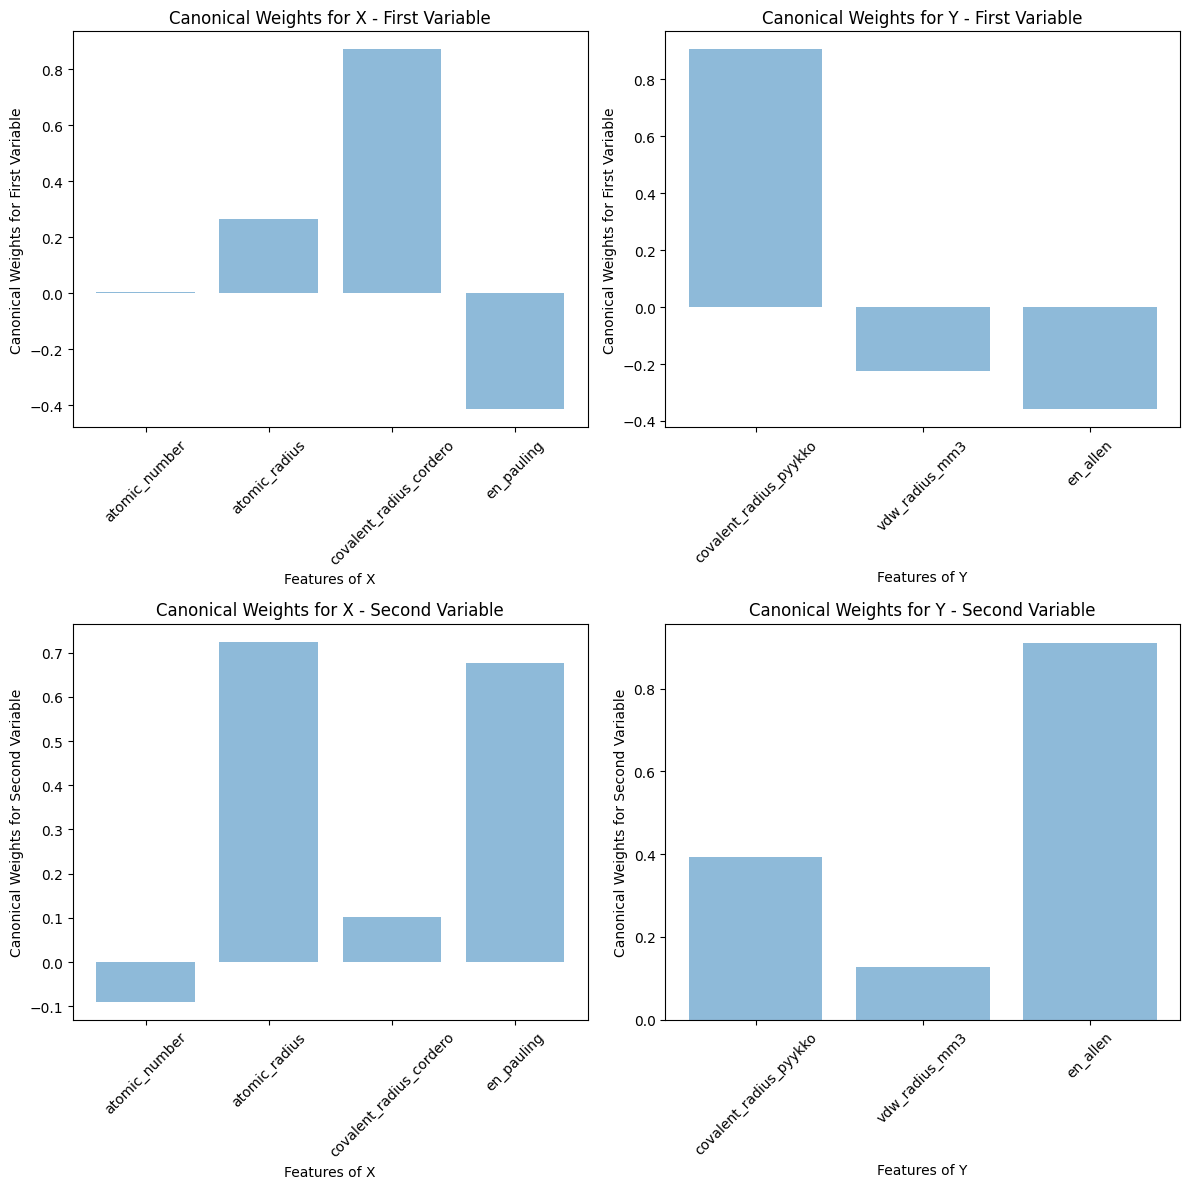

In [10]:
# Get the weights
x_weights = cca.x_weights_
y_weights = cca.y_weights_

# Plot the weights for X
plt.figure(figsize=(12, 12))

# Plot for the first canonical variable for X
plt.subplot(2, 2, 1)
plt.bar(range(x_weights.shape[0]), x_weights[:, 0], alpha=0.5)
plt.xlabel('Features of X')
plt.ylabel('Canonical Weights for First Variable')
plt.title('Canonical Weights for X - First Variable')
plt.xticks(range(x_weights.shape[0]), cols_x, rotation=45)

# Plot for the first canonical variable for Y
plt.subplot(2, 2, 2)
plt.bar(range(y_weights.shape[0]), y_weights[:, 0], alpha=0.5)
plt.xlabel('Features of Y')
plt.ylabel('Canonical Weights for First Variable')
plt.title('Canonical Weights for Y - First Variable')
plt.xticks(range(y_weights.shape[0]), cols_y, rotation=45)

# Plot for the second canonical variable for X
plt.subplot(2, 2, 3)
plt.bar(range(x_weights.shape[0]), x_weights[:, 1], alpha=0.5)
plt.xlabel('Features of X')
plt.ylabel('Canonical Weights for Second Variable')
plt.title('Canonical Weights for X - Second Variable')
plt.xticks(range(x_weights.shape[0]), cols_x, rotation=45)

# Plot for the second canonical variable for Y
plt.subplot(2, 2, 4)
plt.bar(range(y_weights.shape[0]), y_weights[:, 1], alpha=0.5)
plt.xlabel('Features of Y')
plt.ylabel('Canonical Weights for Second Variable')
plt.title('Canonical Weights for Y - Second Variable')
plt.xticks(range(y_weights.shape[0]), cols_y, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

We can also visualize elements in the CCA space

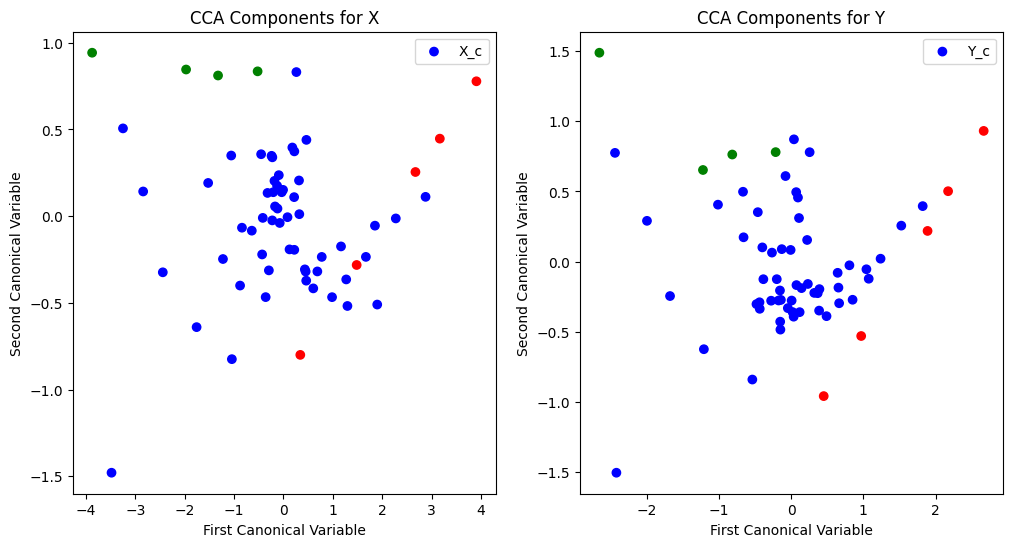

In [11]:
ptable2['label'] = 'other'
ptable2.loc[ptable2['symbol'].isin(['Li', 'Na', 'K', 'Rb', 'Cs']), 'label'] = 'alkali'
ptable2.loc[ptable2['symbol'].isin(['Cl', 'Br', 'I', 'F']), 'label'] = 'halogen'

# Assume X_c is your transformed data
# Plot the data, using different colors for 'alkali' and 'halogen'
colors = ptable2['label'].map({'alkali': 'red', 'halogen': 'green', 'other': 'blue'})

# Plot the first two CCA components
plt.figure(figsize=(12, 6))

# Plot for X_c
plt.subplot(1, 2, 1)
plt.scatter(X_c[:, 0], X_c[:, 1], c=colors, label='X_c')
plt.xlabel('First Canonical Variable')
plt.ylabel('Second Canonical Variable')
plt.title('CCA Components for X')
plt.legend()

# Plot for Y_c
plt.subplot(1, 2, 2)
plt.scatter(Y_c[:, 0], Y_c[:, 1], c=colors, label='Y_c')
plt.xlabel('First Canonical Variable')
plt.ylabel('Second Canonical Variable')
plt.title('CCA Components for Y')
plt.legend()

# Show the plots
plt.show()

# CCA on images

We can also try to use the CCA in order to explore the correlations between e.g. images and their labels, with the idea of building the ML method to convert captions to images and vice versa.

In [12]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

# Load the digits dataset
digits = load_digits()
X = digits.data  # Image data

# Create a one-hot encoded representation of the digit names
names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
y_names = np.array([names[digit] for digit in digits.target])
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y_names.reshape(-1, 1))

# Initialize CCA with the number of components to learn from the data
cca = CCA(n_components=10)
cca.fit(X, Y)

# Transform datasets based on the canonical correlation vectors
X_c, Y_c = cca.transform(X, Y)

# Outputs
print("Canonical correlation coefficients (r):", cca.score(X, Y))
print("Weights for X (canonical correlation vectors):", cca.x_weights_)
print("Weights for Y (canonical correlation vectors):", cca.y_weights_)
#print("Transformed X dataset (first 5 rows):\n", X_c[:5])
#print("Transformed Y dataset (first 5 rows):\n", Y_c[:5])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Canonical correlation coefficients (r): 0.5552374486978752
Weights for X (canonical correlation vectors): [[ 6.86082122e-19 -5.70793213e-18  3.68500820e-18 -2.66297090e-18
   5.57754601e-19  1.91774613e-18 -3.15245273e-18  2.85158225e-18
   4.77149191e-18 -2.99561066e-19]
 [ 3.62247539e-02 -1.41768016e-03 -6.46650166e-02 -2.72665658e-02
  -6.25055247e-03  4.39272202e-02  2.14272291e-02  3.50497770e-02
   1.05488235e-02 -4.72024572e-03]
 [-6.50208563e-02 -6.78254340e-02 -7.54585698e-02 -5.05161988e-02
   3.10546955e-02 -2.32049100e-01  1.45289878e-01 -4.78675257e-02
   2.58625910e-01  6.06475859e-03]
 [-1.61314056e-01 -1.20697454e-01 -8.49459467e-02  6.81579898e-02
   4.26272272e-02  1.51834672e-01  6.32785757e-03  2.29603545e-01
  -2.36035979e-01  6.22605359e-04]
 [-2.33896131e-02 -4.66274945e-02 -8.96144477e-02 -8.51985091e-02
  -5.69391266e-02  5.01378720e-02 -1.55033747e-01 -1.80574050e-01
   2.21348926e-01  9.30436375e-05]
 [-2.65344484e-01  1.16130022e-01 -1.82683875e-01 -2.768533

In [16]:
Y, Y.shape

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 (1797, 10))

In [14]:
cca.score(X, Y), cca.x_weights_.shape,  cca.y_weights_.shape

(0.5552374486978752, (64, 10), (10, 10))

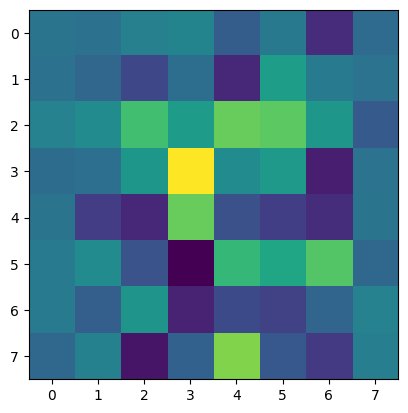

In [15]:
import matplotlib.pyplot as plt

plt.imshow(cca.x_weights_[:,4].reshape(8,8))

Somewhat predictably, it does not work particulalry well. Here, we need to create non-linear embeddings - meaning use DCNNs.